# Vecotor Auto Regression 

#### Motivation :

Came across VAR while studying portfolio optimisation techniques.

Curious to understand how Vector Auto Regression works. How one series is used in combination with other series, to predict a vector of series.

This is built upon Auto Regressive Techniques, and is a multivariate time series analysis technique. 

##### Applications:

Vector auto-regression (VAR) time series model has wide application in econometric forecasting ; 

VAR can capture the evolution and the inter-dependencies between multiple time-series.

# Sources

**Tutorials:**

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

##### What is VAR?

Vector Autoregression (VAR) is a multivariate forecasting algorithm that is used when two or more time series influence each other.

1. Need at least two time series (variables)
2. The time series should influence each other.

It is considered as an Autoregressive model because, each variable (Time Series) is modeled as a function of the past values, that is the predictors are nothing but the lags (time delayed value) of the series.

## Flow of this document:

1. Intuition behind VAR Model formula

2. How to check the bi-directional relationship using Granger Causality

3. Procedure to building a VAR model in Python

4. How to determine the right order of VAR model

5. Interpreting the results of VAR model

6. How to generate forecasts to original scale of time series

#### Intuition 

In VAR we forecast a vector. 

Let's say we are dealing with stocks, then let's say we are forecasting the returns of stocks in a portfolio. 

If one stock in the basket influences the other then, using VAR we forecast the future price of the stocks using not only the lags of that stock but also using the lags of other stocks in the basket. 

**An AR(p) model equation looks like this:**

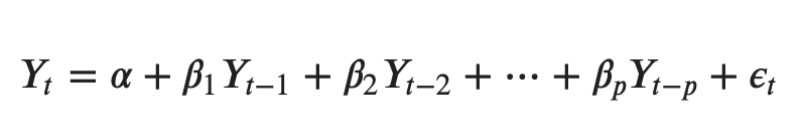

**The system of equations for a VAR(1) model with two time series (variables `Y1` and `Y2`) is as follows:**

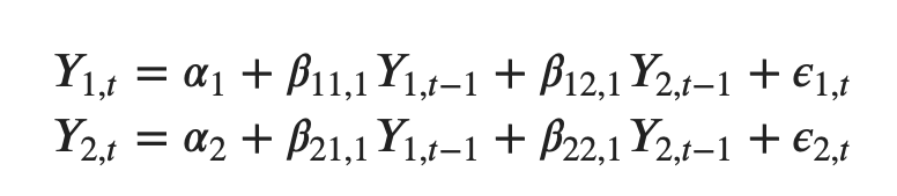

**VAR(2) Model looks like this:**

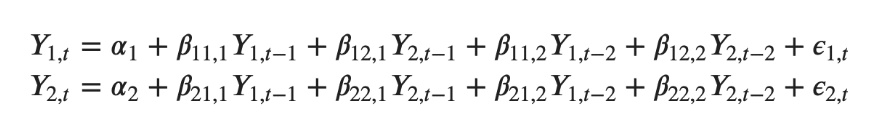

## Building the code for VAR

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

**Data Set Yash P Mehra’s 1994 article: “Wage Growth and the Inflation Process: An Empirical Approach”.**

1. rgnp  : Real GNP.

2. pgnp  : Potential real GNP.

3. ulc   : Unit labor cost.

4. gdfco : Fixed weight deflator for personal consumption expenditure excluding food and energy.

5. gdf   : Fixed weight GNP deflator.

6. gdfim : Fixed weight import deflator.

7. gdfcf : Fixed weight deflator for food in personal consumption expenditure.

8. gdfce : Fixed weight deflator for energy in personal consumption expenditure.

In [4]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
df.head()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8


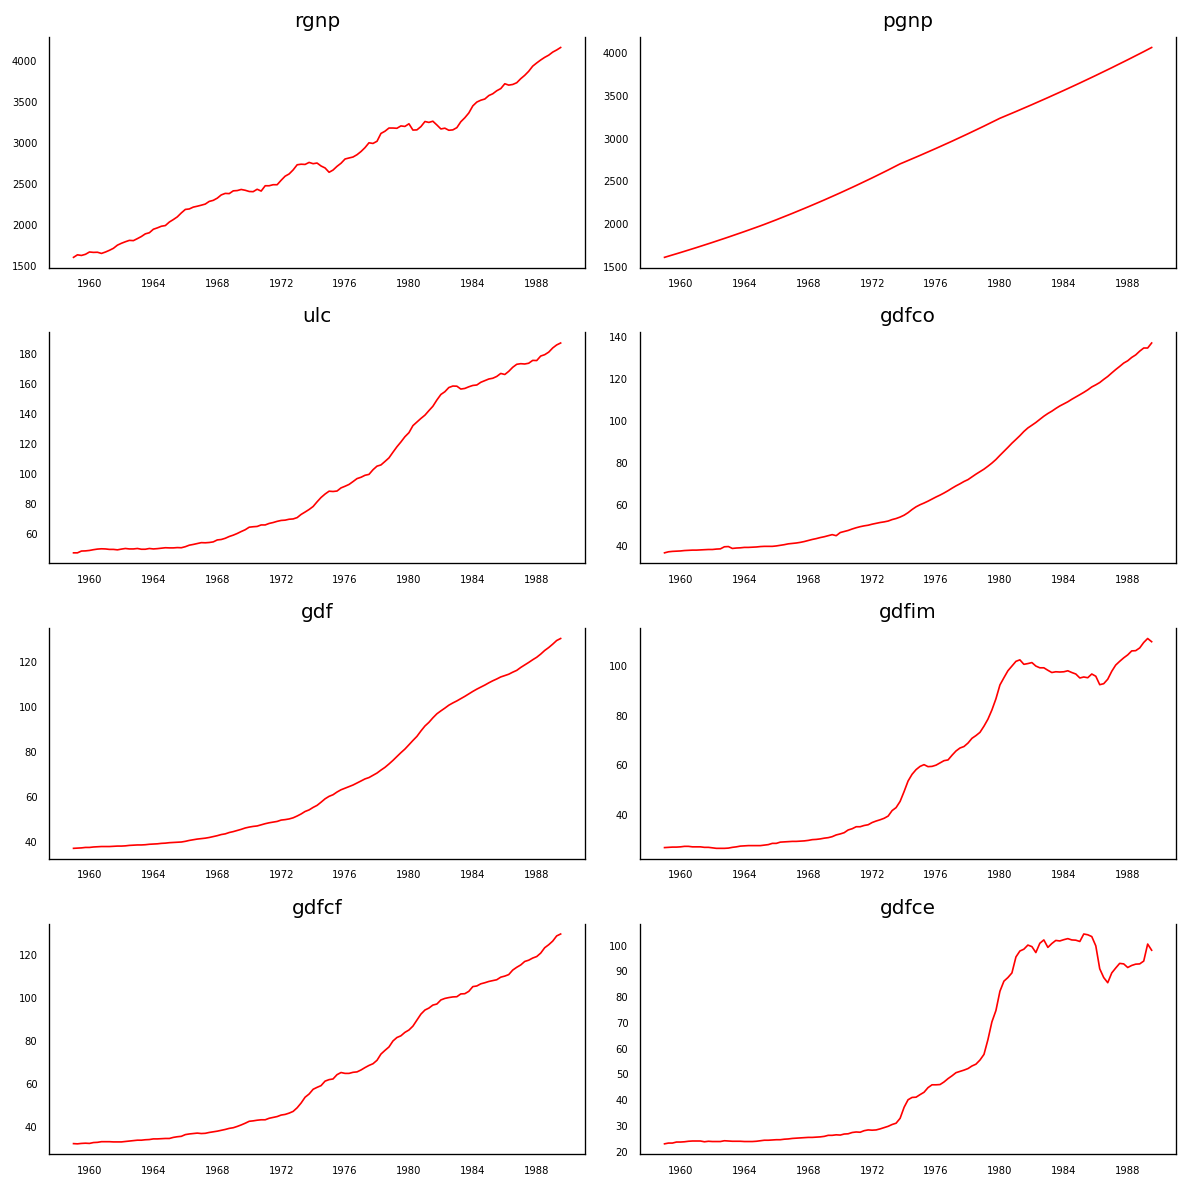

In [7]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

Each of the series have a fairly similar trend patterns over the years except for gdfce and gdfim, where a different pattern is noticed starting in 1980.

### Granger's Causality 

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

Granger’s causality tests the **null hypothesis that the coefficients of past values in the regression equation is zero.**


In [6]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.
    data   : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)   

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0003,0.0001,0.0212,0.0014,0.0620,0.0001,0.0071
pgnp_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ulc_y,0.0000,0.0000,1.0000,0.0002,0.0000,0.0000,0.0000,0.0041
gdfco_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
gdf_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
gdfim_y,0.0011,0.0067,0.0014,0.0083,0.0011,1.0000,0.0004,0.0000
gdfcf_y,0.0000,0.0000,0.0008,0.0008,0.0000,0.0038,1.0000,0.0009
gdfce_y,0.0025,0.0485,0.0000,0.0002,0.0000,0.0000,0.0000,1.0000


If the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

For example, P-Value of 0.0003 at (row 1, column 2) represents the p-value of the Grangers Causality test for pgnp_x causing rgnp_y, which is less that the significance level of 0.05.

So, you can reject the null hypothesis and conclude pgnp_x causes rgnp_y.

Looking at the P-Values in the above table, we can observe that all the variables (time series) in the system are interchangeably causing each other.

This makes this system of multi time series a good candidate for using VAR models to forecast.

## Cointegration Test 

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

#### Cointegration:

Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

When there are two or more time series and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.


When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

This is the basic premise on which Vector Autoregression(VAR) models is based on. So, it’s fairly common to implement the cointegration test before starting to build VAR models

In [6]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>   True
pgnp   ::  183.12    > 111.7797  =>   True
ulc    ::  130.01    > 83.9383   =>   True
gdfco  ::  85.28     > 60.0627   =>   True
gdf    ::  55.05     > 40.1749   =>   True
gdfim  ::  31.59     > 24.2761   =>   True
gdfcf  ::  14.06     > 12.3212   =>   True
gdfce  ::  0.45      > 4.1296    =>   False


#### Train-Test Split 

In [8]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(119, 8)
(4, 8)


In [9]:
df_train.head()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8


#### Stationarity 

Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity.

**Augmented Dickey Fuller test to test stationarity of the data**

In [20]:
from statsmodels.tsa.stattools import adfuller
for i in df_train.columns:
    result = adfuller(df_train[i])
    if result[1] > 0.05:
        print(i  ,"  :  ","p_value>0.05    - non stationary")
    else:
        print(i  ,"  :  ","p_value<0.05    -  stationary")

rgnp   :   p_value>0.05    - non stationary
pgnp   :   p_value>0.05    - non stationary
ulc   :   p_value>0.05    - non stationary
gdfco   :   p_value>0.05    - non stationary
gdf   :   p_value>0.05    - non stationary
gdfim   :   p_value>0.05    - non stationary
gdfcf   :   p_value>0.05    - non stationary
gdfce   :   p_value>0.05    - non stationary


**All the series are non- stationary**

### Differencing to make the series stationary 

##### First Differencing

In [21]:
df_differenced = df_train.diff().dropna()

In [22]:
for i in df_differenced.columns:
    result = adfuller(df_differenced[i])
    if result[1] > 0.05:
        print(i  ,"  :  ","p_value>0.05    - non stationary")
    else:
        print(i  ,"  :  ","p_value<0.05    -  stationary")

rgnp   :   p_value<0.05    -  stationary
pgnp   :   p_value>0.05    - non stationary
ulc   :   p_value<0.05    -  stationary
gdfco   :   p_value>0.05    - non stationary
gdf   :   p_value>0.05    - non stationary
gdfim   :   p_value<0.05    -  stationary
gdfcf   :   p_value>0.05    - non stationary
gdfce   :   p_value<0.05    -  stationary


Some columns have become stationary. While some are not stationary.

##### Thoughts:

All of the series in the VAR model should have the same number of observations.

So, we are left with one of two choices.

That is, either proceed with 1st differenced series or difference all the series one more time.

##### Second Differencing

In [23]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [24]:
#Running the ADF test once again 
for i in df_differenced.columns:
    result = adfuller(df_differenced[i])
    if result[1] > 0.05:
        print(i  ,"  :  ","p_value>0.05    - non stationary")
    else:
        print(i  ,"  :  ","p_value<0.05    -  stationary")


rgnp   :   p_value<0.05    -  stationary
pgnp   :   p_value<0.05    -  stationary
ulc   :   p_value<0.05    -  stationary
gdfco   :   p_value<0.05    -  stationary
gdf   :   p_value<0.05    -  stationary
gdfim   :   p_value<0.05    -  stationary
gdfcf   :   p_value<0.05    -  stationary
gdfce   :   p_value<0.05    -  stationary


##### Result:

All the columns are stationary now!

# Preparing the model 

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

In [25]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -1.3679402315450646
BIC :  0.34118471465888556
FPE :  0.25526825173472023
HQIC:  -0.6741331335699536 

Lag Order = 2
AIC :  -1.6212373944478244
BIC :  1.6249432095295844
FPE :  0.20113494371371382
HQIC:  -0.30362888267959276 

Lag Order = 3
AIC :  -1.7658008387012791
BIC :  3.0345473163767833
FPE :  0.18125103746164364
HQIC:  0.18239143783963296 

Lag Order = 4
AIC :  -2.000735164470318
BIC :  4.3712151376540875
FPE :  0.15556966521481097
HQIC:  0.5849359332771069 

Lag Order = 5
AIC :  -1.9619535608363954
BIC :  5.9993645622420955
FPE :  0.18692794389114886
HQIC:  1.268206331178333 

Lag Order = 6
AIC :  -2.3303386524829106
BIC :  7.238452689088575
FPE :  0.16380374017443577
HQIC:  1.551437166954802 

Lag Order = 7
AIC :  -2.5923313523471325
BIC :  8.602387254937792
FPE :  0.18238685837154078
HQIC:  1.9483069621146516 

Lag Order = 8
AIC :  -3.3172619764582034
BIC :  9.522195810323032
FPE :  0.15573163248209115
HQIC:  1.8896071386221003 

Lag Order = 9
AIC :  -4.8

C:\Users\sreek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


In the above output, the AIC drops to lowest at lag 4, then increases at lag 5 and then continuously drops further.

Let’s go with the lag 4 model.

An alternate method to choose the order(p) of the VAR models is to use the model.select_order(maxlags) method.

The selected order(p) is the order that gives the lowest ‘AIC’, ‘BIC’, ‘FPE’ and ‘HQIC’ scores.

In [26]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-0.07898,0.1232,0.9241,0.002961
1,-0.5721,1.248,0.5662,0.1653
2,-0.8256,2.612,0.4482,0.5674
3,-1.007,4.048,0.3937,1.042
4,-1.255,5.418,0.3399,1.449
5,-1.230,7.060,0.4147,2.129
6,-1.739,8.169,0.3286,2.276
7,-2.142,9.384,0.3340,2.528
8,-2.964,10.18,0.2744,2.362
9,-4.562,10.20,0.1413,1.420


**Doubt here will have to check further

# Training the model based on selected order

In [28]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Jul, 2022
Time:                     19:54:22
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.37122
Nobs:                     113.000    HQIC:                  0.584936
Log likelihood:          -905.679    FPE:                   0.155570
AIC:                     -2.00074    Det(Omega_mle):       0.0200322
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.430021         2.677505            0.908           0.364
L1.rgnp         -0.750066         0.159023           -4.717           0.000
L1.pgnp         -0.095621         4.938865           -0.019           0.985
L1.ul

#### Understanding the regression output 

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic.

The value of this statistic can vary between 0 and 4. 
The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, 
and the closer it is to 4 implies negative serial correlation.

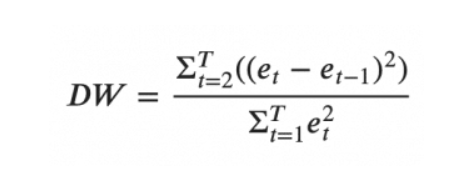

In [30]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

rgnp : 2.09
pgnp : 2.02
ulc : 2.17
gdfco : 2.05
gdf : 2.25
gdfim : 1.99
gdfcf : 2.2
gdfce : 2.17


The multicolliniarity seems quite alright. We can proceed with the model!

# Forecasting

In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [31]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

4


In [33]:
df_differenced.tail() #This is the training data 

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1987-07-01,8.8,0.1,0.7,-0.1,0.0,-1.0,-1.0,-0.1
1987-10-01,13.5,0.1,1.4,0.1,0.1,-0.1,0.4,-2.0
1988-01-01,-23.6,0.2,-2.0,-0.5,-0.1,-0.2,-0.3,-1.2
1988-04-01,-3.3,0.1,3.1,0.5,0.3,0.4,0.9,2.2
1988-07-01,-3.9,0.2,-2.1,-0.4,0.2,-1.5,0.9,-0.3


In [32]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 13.5,   0.1,   1.4,   0.1,   0.1,  -0.1,   0.4,  -2. ],
       [-23.6,   0.2,  -2. ,  -0.5,  -0.1,  -0.2,  -0.3,  -1.2],
       [ -3.3,   0.1,   3.1,   0.5,   0.3,   0.4,   0.9,   2.2],
       [ -3.9,   0.2,  -2.1,  -0.4,   0.2,  -1.5,   0.9,  -0.3]])

In [34]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,rgnp_2d,pgnp_2d,ulc_2d,gdfco_2d,gdf_2d,gdfim_2d,gdfcf_2d,gdfce_2d
date,,,,,,,,
1988-10-01,48.322456,1.250774,0.595993,0.265657,-0.104146,0.304119,-0.917227,-0.113061
1989-01-01,-34.962286,-0.387966,-0.329877,-0.042217,0.164633,1.357223,0.618163,3.029975
1989-04-01,20.392680,0.291298,0.390812,-0.134488,-0.486073,-0.149551,-1.238234,-2.345223
1989-07-01,-37.416599,-0.280943,0.367912,0.102797,0.333371,-0.502103,0.469468,0.517424


The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, you need to de-difference it as many times you had differenced the original input data.

In [37]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [39]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

,rgnp_forecast,pgnp_forecast,ulc_forecast,gdfco_forecast,gdf_forecast,gdfim_forecast,gdfcf_forecast,gdfce_forecast
date,,,,,,,,
1988-10-01,4123.022456,3996.950774,181.095993,132.965657,126.395854,106.604119,125.082773,93.186939
1989-01-01,4168.382626,4021.613582,182.262108,134.389097,128.056341,108.365461,127.283708,96.603854
1989-04-01,4234.135476,4046.567687,183.819036,135.678050,129.230756,109.977252,128.246409,97.675545
1989-07-01,4262.471728,4071.240850,185.743875,137.069799,130.738542,111.086940,129.678579,99.264661


The forecasts are back to the original scale. Let’s plot the forecasts against the actuals from test data.

# Forecast vs Actuals plot

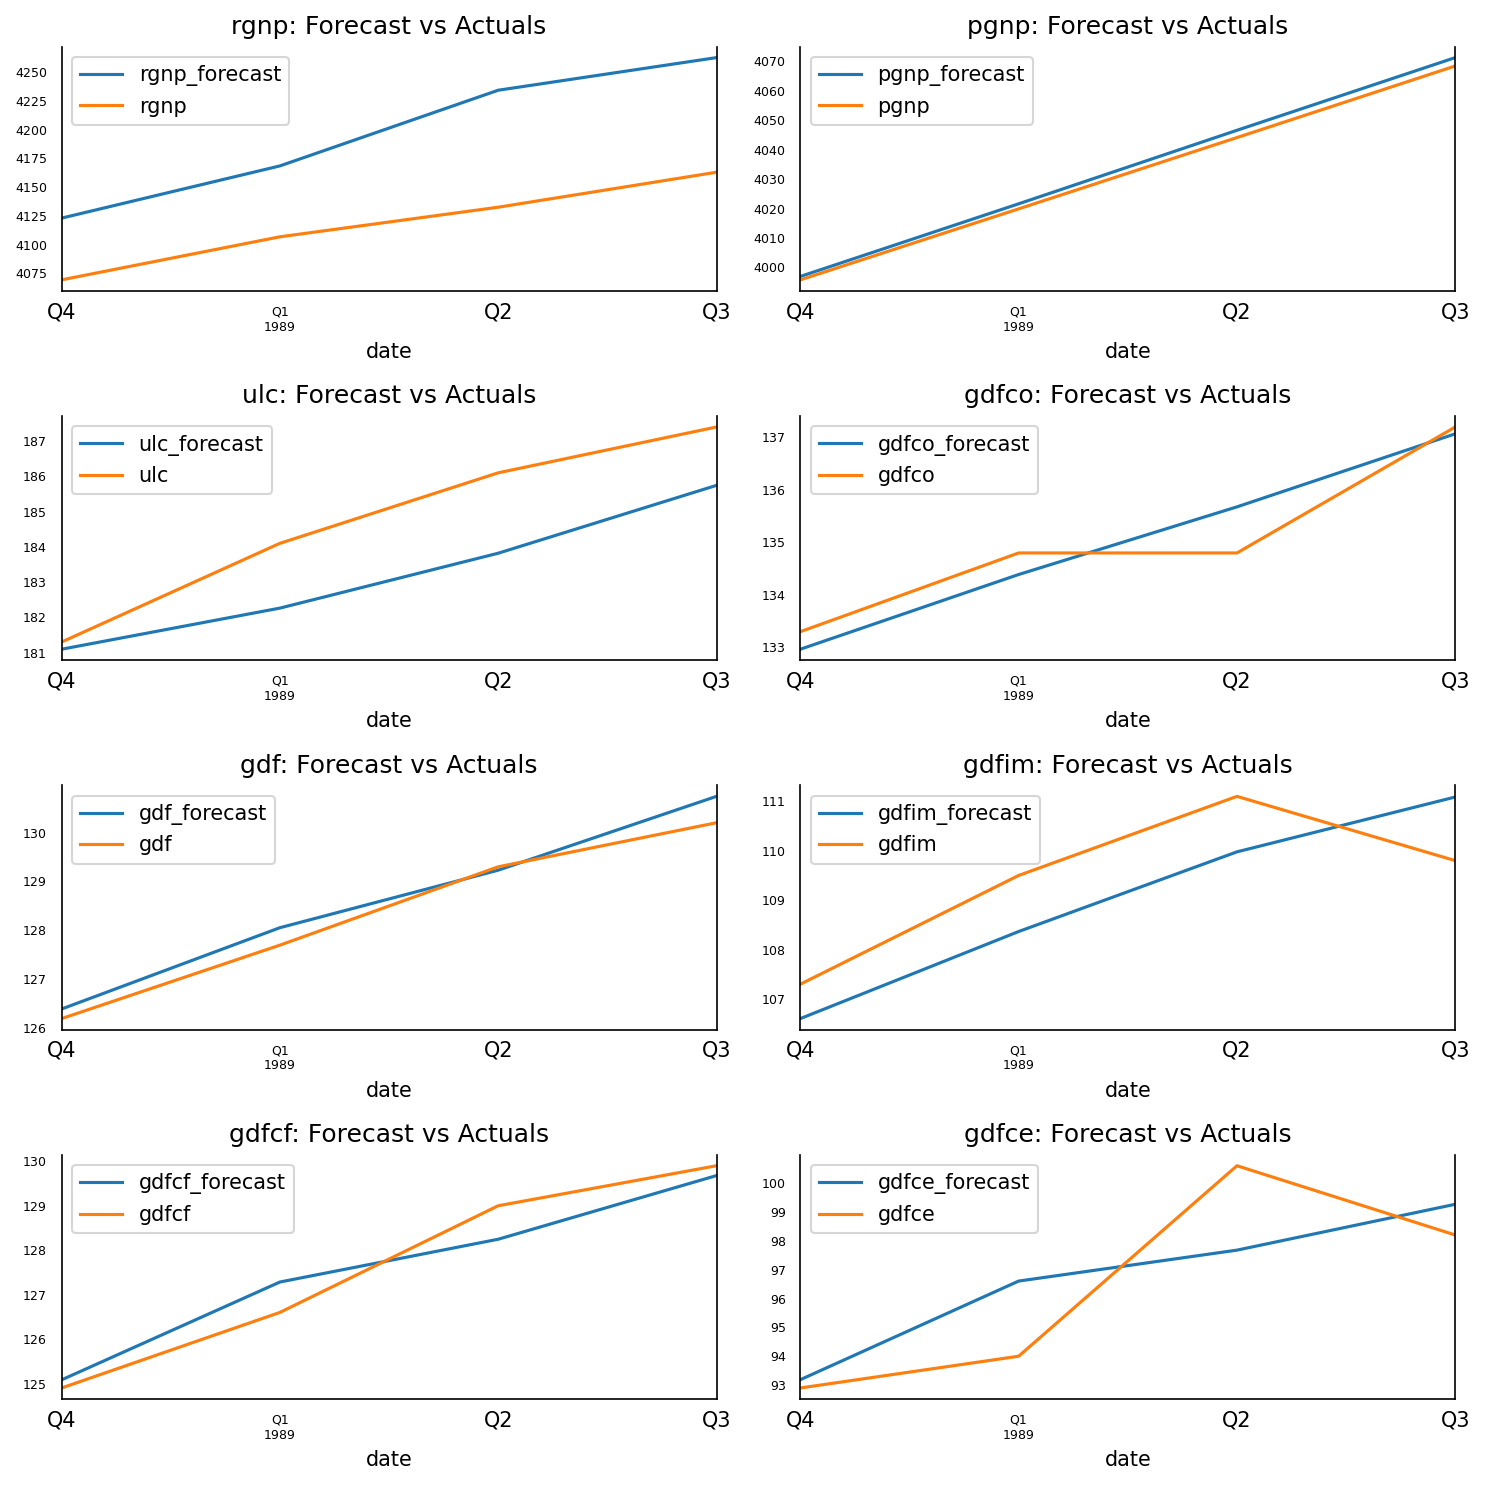

In [40]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Evaluating the Forecasts

In [43]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print((k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape :  0.0192
me :  79.1031
mae :  79.1031
mpe :  0.0192
rmse :  82.0245
corr :  0.9849
minmax :  0.0188

Forecast Accuracy of: pgnp
mape :  0.0005
me :  2.0432
mae :  2.0432
mpe :  0.0005
rmse :  2.146
corr :  1.0
minmax :  0.0005

Forecast Accuracy of: ulc
mape :  0.0081
me :  -1.4947
mae :  1.4947
mpe :  -0.0081
rmse :  1.6856
corr :  0.963
minmax :  0.0081

Forecast Accuracy of: gdfco
mape :  0.0033
me :  0.0007
mae :  0.4384
mpe :  0.0
rmse :  0.5169
corr :  0.9407
minmax :  0.0032

Forecast Accuracy of: gdf
mape :  0.0023
me :  0.2554
mae :  0.29
mpe :  0.002
rmse :  0.3392
corr :  0.9905
minmax :  0.0022

Forecast Accuracy of: gdfim
mape :  0.0097
me :  -0.4166
mae :  1.06
mpe :  -0.0038
rmse :  1.0826
corr :  0.807
minmax :  0.0096

Forecast Accuracy of: gdfcf
mape :  0.0036
me :  -0.0271
mae :  0.4604
mpe :  -0.0002
rmse :  0.5286
corr :  0.9713
minmax :  0.0036

Forecast Accuracy of: gdfce
mape :  0.0177
me :  0.2577
mae :  1.72
mpe :  0.0031
rmse 

C:\Users\sreek\AppData\Local\Temp/ipykernel_26284/3421759270.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\sreek\AppData\Local\Temp/ipykernel_26284/3421759270.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


# Checking Granger's causation on stock market data 

In [44]:
# Load packages 
import numpy as np 
import pandas as pd 
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
# Read Data 
test = data.DataReader(['MARUTI.NS','M&M.NS','TATAMOTORS.NS','BAJAJ-AUTO.NS','HEROMOTOCO.NS'],'yahoo',start = '2017/01/01',end = "2021/12/31")
test.head()

Attributes    Adj Close                                                        \
Symbols       MARUTI.NS      M&M.NS TATAMOTORS.NS BAJAJ-AUTO.NS HEROMOTOCO.NS   
Date                                                                            
2017-01-02  5164.376953  580.784302    487.049988   2176.260498   2555.635742   
2017-01-03  5204.437012  577.360352    481.100006   2193.596924   2518.531494   
2017-01-04  5198.532227  577.076965    486.649994   2247.950928   2534.005371   
2017-01-05  5324.004395  579.627258    502.149994   2280.822998   2590.379395   
2017-01-06  5305.674316  576.368652    497.750000   2267.423340   2586.837891   

Attributes        Close                                                        \
Symbols       MARUTI.NS      M&M.NS TATAMOTORS.NS BAJAJ-AUTO.NS HEROMOTOCO.NS   
Date                                                                            
2017-01-02  5466.000000  614.900024    487.049988   2598.500000   3030.550049   
2017-01-03  5508.399902  611.275024    481.100006   2619.199951   2986.550049   
2017-01-04  5502.149902  610.974976    486.649994   2684.100098   3004.899902   
2017-01-05  5634.950195  613.674988    502.149994   2723.350098   3071.750000   
2017-01-06  5615.549805  610.224976    497.750000   2707.350098   3067.550049   

Attributes  ...         Open                                          \
Symbols     ...    MARUTI.NS      M&M.NS TATAMOTORS.NS BAJAJ-AUTO.NS   
Date        ...                                                        
2017-01-02  ...  5320.049805  592.250000    472.000000   2642.699951   
2017-01-03  ...  5466.000000  615.000000    491.000000   2594.000000   
2017-01-04  ...  5530.000000  611.325012    484.649994   2625.199951   
2017-01-05  ...  5525.100098  612.000000    496.000000   2694.000000   
2017-01-06  ...  5650.000000  619.500000    502.950012   2721.000000   

Attributes                  Volume                                         \
Symbols    HEROMOTOCO.NS MARUTI.NS     M&M.NS TATAMOTORS.NS BAJAJ-AUTO.NS   
Date                                                                        
2017-01-02   3042.000000  651321.0  2106528.0     4024156.0      323342.0   
2017-01-03   2978.000000  631753.0  1553022.0     5814518.0      420196.0   
2017-01-04   2999.000000  679443.0  1130816.0     4769872.0      343922.0   
2017-01-05   3034.899902  744210.0  2508486.0     7961242.0      188686.0   
2017-01-06   3085.000000  544695.0  2254066.0     4907475.0      159484.0   

Attributes                
Symbols    HEROMOTOCO.NS  
Date                      
2017-01-02      213654.0  
2017-01-03      454277.0  
2017-01-04      396816.0  
2017-01-05      383925.0  
2017-01-06      266915.0  

[5 rows x 30 columns]

In [59]:
# Closing price 
test = test["Close"]
test.head()

Symbols,MARUTI.NS,M&M.NS,TATAMOTORS.NS,BAJAJ-AUTO.NS,HEROMOTOCO.NS
Date,,,,,
2017-01-02,5466.000000,614.900024,487.049988,2598.500000,3030.550049
2017-01-03,5508.399902,611.275024,481.100006,2619.199951,2986.550049
2017-01-04,5502.149902,610.974976,486.649994,2684.100098,3004.899902
2017-01-05,5634.950195,613.674988,502.149994,2723.350098,3071.750000
2017-01-06,5615.549805,610.224976,497.750000,2707.350098,3067.550049


In [62]:
test.columns

Index(['MARUTI.NS', 'M&M.NS', 'TATAMOTORS.NS', 'BAJAJ-AUTO.NS',
       'HEROMOTOCO.NS'],
      dtype='object', name='Symbols')

<AxesSubplot:xlabel='Date'>

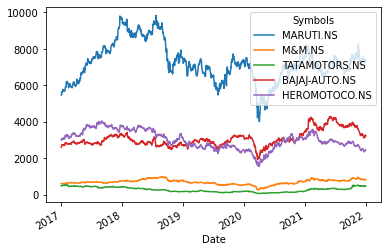

In [64]:
# Plotting the data 
test.plot()

# Granger's Causation:

The Granger causality test is a statistical hypothesis test for determining whether one time series is useful for forecasting another. If probability value is less than any α level, then the hypothesis would be rejected at that level.

The row are the response (y) and the columns are the predictors (x).

 If a given p-value is < significance level (0.05)
 
Assumptions The Granger Causality test assumes that both the x and y time series are stationary. If this is not the case, then differencing, de-trending or other techniques must first be employed before using the Granger Causality test.

In [65]:
grangers_causation_matrix(test, variables = test.columns)   

C:\Users\sreek\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 8, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\sreek\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\sreek\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\sreek\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 1
  warnings.warn('covariance of constraints does not have full 

,MARUTI.NS_x,M&M.NS_x,TATAMOTORS.NS_x,BAJAJ-AUTO.NS_x,HEROMOTOCO.NS_x
MARUTI.NS_y,1.0000,0.0840,0.1499,0.2089,0.0059
M&M.NS_y,0.1021,1.0000,0.2243,0.0768,0.0758
TATAMOTORS.NS_y,0.0828,0.0261,1.0000,0.0060,0.5027
BAJAJ-AUTO.NS_y,0.1068,0.3978,0.1291,1.0000,0.2051
HEROMOTOCO.NS_y,0.0099,0.0585,0.3715,0.0628,1.0000


Here we see that not all the variables are having grangers_causality. 



**The end.**